# Studies about gravitational waves, glitches on O3 run data - We need be able to obtain data from LIGO, HANFORD and VIRGO interferometers, manipulate this data and plot the results from O3 run.

## 1 Introduction

First we need import the necessary libraries

In [13]:
import pandas as pd
import matplotlib.pyplot as plt


import seaborn as sns
import warnings
import math
import numpy as np
import datetime
import matplotlib.dates as mdates

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

from astropy.time import Time
# from gwosc.datasets import event_gps
# from gwpy.timeseries import TimeSeries

import frequency_functions as ff

We can collect data in two main ways:

1 - from LigoDV-web (H1, L1, V1 - https://login.ligo.org/idp/profile/SAML2/Redirect/SSO?execution=e1s2) that **need of your LIGO credentials**.

2 - from Zenodo website (H1, L1 - https://zenodo.org/records/5649212) that **does't have V1 data**.

A brief explanation of how to import this data across websites can be found at - **???**.

## 2 Clean the data and filter interesting features

You can make this all process with any interferometers. In our case is V1 from LigoDV-web.

### 2.1 To see the data in dataFrame mode, use pandas libraries

* **The O3 run have some duplicates data, depending on the source you got the data. This happens because some sources get data from multiple interferometers, or because the data have overlapping data segments in time windows. Furthermore, during data cleaning or combining different glitch catalogs (e.g., Gravity Spy + Omicron), indentical glitches might be added more than once. So, we use df.drop_duplicates()**

In [21]:
dfligo_V1_O3a = pd.read_csv("O3run data/V1_O3a_gspyLIGO.csv").drop_duplicates()
dfligo_V1_O3b = pd.read_csv("O3run data/V1_O3b_gspyLIGO.csv").drop_duplicates()

dfligo_V1_O3a.tail()

,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,id,ifo,label,imgUrl,Q-value
80393,1.253167e+09,21.276,7.905,1.460000e-21,3680.246,2.013,7328.491699,0.0,0.0,0.187,axFS82a5rf,V1,Light_Modulation,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,22.627
80394,1.253478e+09,19.950,7.959,1.800000e-21,42.988,0.500,53.975620,0.0,0.0,0.184,aH3vyF6Rc1,V1,None_of_the_Above,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,22.627
80395,1.244633e+09,418.816,8.968,2.010000e-22,302.104,0.359,547.768860,0.0,0.0,0.177,fgQ0bycRBj,V1,None_of_the_Above,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,22.627
80396,1.240533e+09,116.576,10.334,1.270000e-22,109.385,0.375,182.753067,0.0,0.0,0.172,vmTmg3Y2x0,V1,Scratchy,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,11.314
80397,1.241687e+09,349.985,8.376,1.570000e-22,324.817,0.703,600.853760,0.0,0.0,0.161,0o9ovV7MEB,V1,Koi_Fish,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,22.627


### 2.2 To only filter glitches that have confidence vales above 90%

* **The reason why pipelines like Gravity Spy have relatively few glitches classified with confidence above 90% is due to a combination of factors. Glitches are highly diverse and often ambiguous, making them hard to classify with certainty. The machine learning models used are cautious and assign high confidence only when the classification is very clear. Additionally, the training data may be imbalanced, with some glitch types being rare or underrepresented. Visual similarities between categories can also reduce confidence. As a result, most confidence scores tend to fall below the 90% threshold, which is expected in complex multi-class classification problems.**

A lot glitches have no high confidence from its pipeline classification, see

In [90]:
above_90percent = (dfligo_V1_O3a['confidence'] >= 0.9).sum()
total = len(dfligo_V1_O3a)

percent = above_90percent / total
percent

0.5745789696261101

So lets only filter this nice glitches confidence for our analysis. The length of our data was decreased, see

In [93]:
clean_V1_O3a = dfligo_V1_O3a[dfligo_V1_O3a['confidence'] >= 0.9]
clean_V1_O3b = dfligo_V1_O3b[dfligo_V1_O3b['confidence'] >= 0.9]

clean_V1_O3a.shape

(46195, 15)

## 3 Analyze the frequency of each categorized glitch of O3 in general, but also splitting the analysis for O3a (April 1st 2019 - October 1st 2019) and O3b (November 1st 2019 - March 27th 2020) runs

### 3.1 The dominance of each glitch in O3a run

* **During the O3a and O3b observing runs, there was a clear dominance of certain glitch types, both in quantity and persistence over time. Blip glitches were especially prevalent during O3a, appearing frequently and relatively uniformly across different months. Other commonly observed types included scattered light, often associated with nighttime or seismic activity, and power line glitches, which are linked to persistent electrical noise. In contrast, categories such as low-frequency burst or 1400 ripple were much rarer and more localized, making statistical analysis and classifier training more difficult. This imbalance in glitch occurrence reflects both instrumental and environmental conditions that influence detector sensitivity and the nature of noise sources during different phases of the observation run.**

To count each glitch that we have, we use the **.value_counts()** function in the column **"label"** of our data

* If you prefer, the function **.nlargest(m)** after **.value_counts()** select the **"m"** biggest

In [181]:
glitch_countsO3a = clean_V1_O3a['label'].value_counts().sort_values(ascending=True)

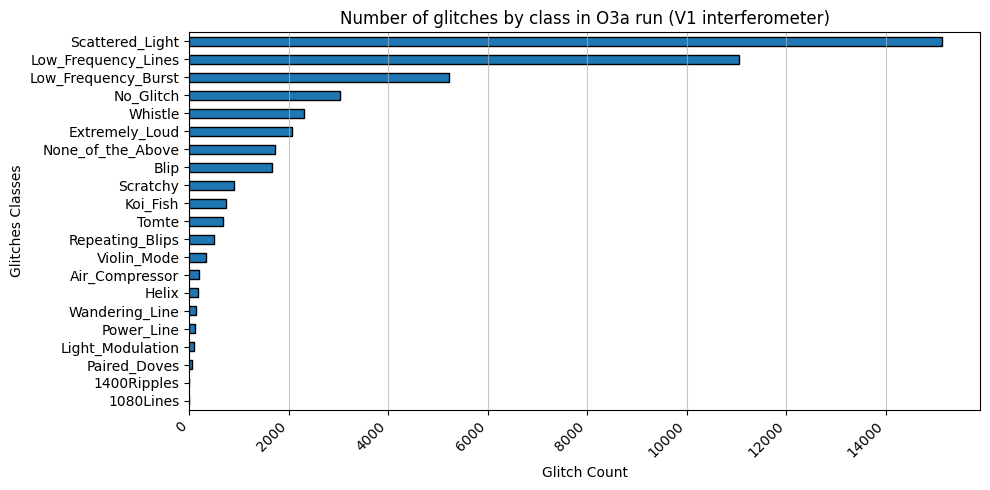

In [196]:
plt.figure(figsize=(10, 5))
glitch_countsO3a.plot(kind='barh', edgecolor='black')

plt.title('Number of glitches by class in O3a run (V1 interferometer)')
plt.xlabel('Glitch Count')
plt.ylabel('Glitches Classes')
plt.xticks(rotation=45, ha='right')  # Rotaciona os nomes dos glitches

plt.grid(axis='x', linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()

And for O3b run we have
### 3.2 And for O3b run we have

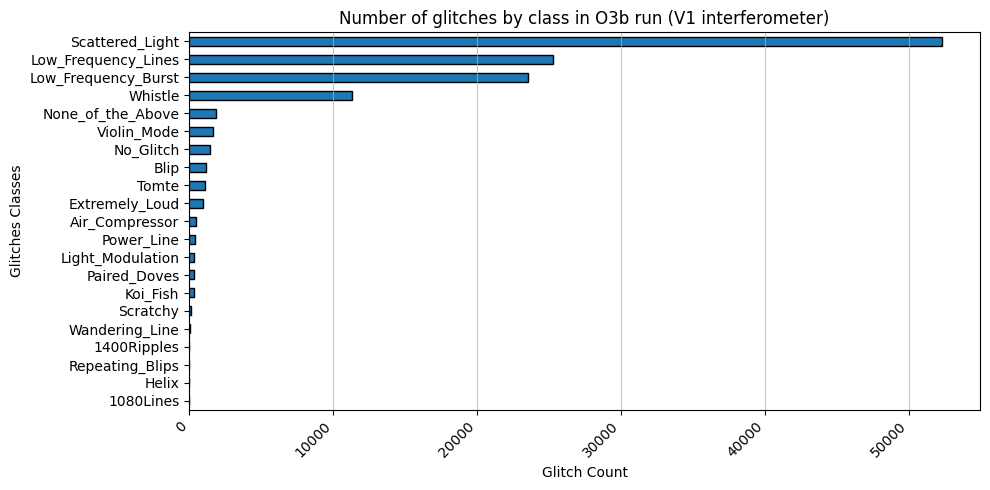

In [198]:
glitch_countsO3b = clean_V1_O3b['label'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(10, 5))
glitch_countsO3b.plot(kind='barh', edgecolor='black')

plt.title('Number of glitches by class in O3b run (V1 interferometer)')
plt.xlabel('Glitch Count')
plt.ylabel('Glitches Classes')
plt.xticks(rotation=45, ha='right')  # Rotaciona os nomes dos glitches

plt.grid(axis='x', linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()

We can see that **scattering-light** (and **fast-scattering** inside it) are the glitches that occurred the most during the O3b run - around November 1st 2019 - March 27th 2020. This agreed with Tabata teses (https://www.gov.br/inpe/pt-br/area-conhecimento/posgraduacao/ast/repositorio-de-arquivos/teses/tese_tabata_aira_ferreira.pdf)

## 4 Time-tracking of the incidence of each glitch category throughout O3 (by monthly, season, …)

In [129]:
df_sortedO3a = df2ligo_V1_O3a.sort_values(by='GPStime', ascending=True)
df_sortedO3b = df2ligo_V1_O3b.sort_values(by='GPStime', ascending=True)

df_sortedO3a = df_sortedO3a.reset_index(drop=True)
df_sortedO3b = df_sortedO3b.reset_index(drop=True)

print(df_sortedO3a.index)
df_sortedO3a.head()

RangeIndex(start=0, stop=80398, step=1)


,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,id,ifo,label,imgUrl,Q-value
0,1.238166e+09,118.526,12.088,1.090000e-22,211.877,0.094,331.946350,0.0,0.0,1.000,U9hF0CFicL,V1,Blip,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,5.657
1,1.238167e+09,19.950,7.867,2.590000e-21,20.195,0.750,8.390090,0.0,0.0,0.998,cFEXeEnnvv,V1,Low_Frequency_Lines,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,22.627
2,1.238167e+09,41.312,8.180,2.460000e-22,65.530,0.078,82.279373,0.0,0.0,1.000,7Rmzlmneu5,V1,Blip,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,5.657
3,1.238167e+09,19.056,8.306,3.290000e-21,19.370,1.750,2.439150,0.0,0.0,0.965,pwXEfq8DlK,V1,Low_Frequency_Lines,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,45.255
4,1.238168e+09,340.202,12.113,1.970000e-22,357.194,0.313,218.644699,0.0,0.0,1.000,wiP1dmnUtc,V1,Whistle,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,45.255


## Funções para plots em linha

In [387]:
# some glitches that you can use

'''
Scattered_Light            Koi_Fish
Low_Frequency_Lines        Tomte
Low_Frequency_Burst        Violin_Mode
                           Blip 
'''

# glitches_number, glitches_chosen, time_key = ff.call_function()

data = df_sortedO3a.copy()
glitches_number = 4
glitches_chosen = ['Scattered_Light', 'Low_Frequency_Lines', 'Low_Frequency_Burst', 'Koi_Fish']
time_key = 'w'

In [389]:
# função para analisar dependencias nos inputs

ff.inputs_dependences(data, glitches_number, glitches_chosen, time_key)

Todos os nomes escolhidos são válidos!


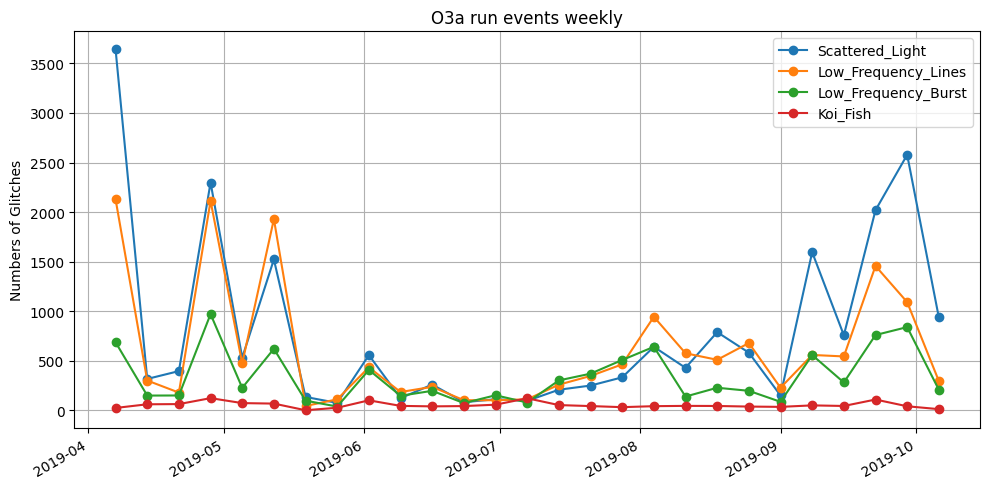

In [391]:
ff.plot_function(data, glitches_number, glitches_chosen, time_key)